In [15]:
## General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Model imports
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Steps:

1. Import raw dataset
2. Preprocess and feature engineering
3. Split train and test datasets
4. (optional) Apply scaling function to the train and test sets separately
5. Train the model and evaluate

In [58]:
# 1. Importing the raw dataset

training_values = "~/Coding/drivendata/pump-it-up/data/raw/TrainingSetValues.csv"
training_labels = "~/Coding/drivendata/pump-it-up/data/raw/TrainingSetLabels.csv"

vals = pd.read_csv(training_values)
labels = pd.read_csv(training_labels)

df = pd.merge(
    left=vals,
    right=labels,
    on='id'
)

In [59]:
# 2. Preprocessing and feature engineering

def preprocessing(df):

    #--- convert to datetime and add month_recorded column ---#
    df['date_recorded'] = pd.to_datetime(df.date_recorded, format='%Y-%m-%d')
    df['month_recorded'] = df.date_recorded.dt.month

    #--- fix the population field whereas 0 is actually a null value ---#
    df.population.replace(0.0,np.nan,inplace=True)
    df['population'].fillna(df.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
    df['population'].fillna(df.groupby(['region'])['population'].transform('median'), inplace=True)
    df['population'].fillna(df['population'].median(), inplace=True)

    #--- fix the gps_height field whereas 0 is actually a null value ---#
    df.gps_height.replace(0.0,np.nan,inplace=True)
    df['gps_height'].fillna(df.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
    df['gps_height'].fillna(df.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
    df['gps_height'].fillna(df['gps_height'].mean(), inplace=True)

    #--- fix the latitude and longitude fields whereas 0 is actually a null value ---#
    df.latitude.replace(0.0,np.nan,inplace=True)
    df.longitude.replace(0.0,np.nan,inplace=True)
    df['latitude'].fillna(df.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
    df['latitude'].fillna(df.groupby(['region'])['latitude'].transform('mean'), inplace=True)
    df['latitude'].fillna(df['latitude'].mean(), inplace=True)
    df['longitude'].fillna(df.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
    df['longitude'].fillna(df.groupby(['region'])['longitude'].transform('mean'), inplace=True)
    df['longitude'].fillna(df['longitude'].mean(), inplace=True)

    #--- fix the construction_year field whereas 0 is actually a null value ---#
    # df.loc[(df.date_recorded.dt.year - df.construction_year) < 0, 'construction_year'] = 0.0
    df['construction_year'].replace(0.0, np.nan, inplace=True)
    df['construction_year'].fillna(df.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
    df['construction_year'].fillna(df.groupby(['region'])['construction_year'].transform('median'), inplace=True)
    df['construction_year'].fillna(df.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    df['construction_year'].fillna(df['construction_year'].median(), inplace=True)

    #--- short rains are usually between Oct and Dec, long rains between Mar and May ---#
    rains = [3,4,5,10,11,12]

    def rainy_season(series):
        if series in rains:
            return 1
        else:
            return 0

    df['rainy_season'] = df.month_recorded.apply(rainy_season)

    #--- adding column age of water point at the time of assessment ---#
    #--- if the age is negative (mistake in recorded date or construction year), round it to 0 ---#
    df['age_yrs'] = df.date_recorded.dt.year - df.construction_year
    df.loc[df.age_yrs < 0, 'age_yrs'] = 0

    #--- changing column 'num_private' to boolean and renaming it to 'private_conn' ---#
    df.loc[df.num_private == 0, 'num_private'] = 0
    df.loc[df.num_private > 0, 'num_private'] = 1
    df.rename(columns={'num_private': 'private_conn'}, inplace=True)
    
    #--- in column 'installer' replace with 'other' anything which is not DWE or government ---#
    df['installer'] = df.installer.str.lower()
    df['installer'] = df.installer.fillna('unknown')

    dwe_pattern = []
    gov_pattern = []

    for i in df.installer.unique():
        import re
        if re.search("(dwe)", i, re.IGNORECASE):
            dwe_pattern.append(i)
        elif re.search("(government)", i, re.IGNORECASE):
            gov_pattern.append(i)

    def installer_group(data):
        if data.installer in dwe_pattern:
            return 'DWE'
        elif data.installer in gov_pattern:
            return 'government'
        else:
            return 'other'

    df['installer'] = df.apply(installer_group, axis=1)

    #--- in column 'funder' replace with 'other' all missing values ---#
    #--- and then factorize it (there are too many distinct value to create dummy) ---#
    df['funder'] = df.funder.str.lower()
    df['funder'] = df.funder.fillna('other')
    df['funder'] = pd.factorize(df.funder)[0]

    #--- drop unnecessary columns ---#
    cols_to_drop = [
        'amount_tsh', 
        'funder',
        # 'installer',
        'wpt_name', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'scheme_name',  
        'recorded_by',
        'scheme_management', 'management',
        'extraction_type', 'extraction_type_group', 
        'payment',
        'water_quality', 'quantity', 'source', 'source_class', 'waterpoint_type',
        'construction_year', 'date_recorded',
    ]
    
    df.drop(cols_to_drop, axis=1, inplace=True)

    #--- the remaining columns with null values are 'public_meeting' and 'permit' ---#
    #--- replace null value with 'unknown' ---#
    # df.replace(True, 1, inplace=True)
    # df.replace(False, 0, inplace=True)
    df.fillna('unknown', inplace=True)
    
    #--- factorize the target variable ---#
    df.replace('functional', 0, inplace=True)
    df.replace('non functional', 1, inplace=True)
    df.replace('functional needs repair', 2, inplace=True)

    return df

def feature_eng(df):
    cat_cols = df.select_dtypes(include='object').columns
    cat_cols = cat_cols.to_list()
    cat_cols.append('month_recorded')
    
    return pd.get_dummies(data=df, columns=cat_cols, drop_first=True)


In [60]:
dff = feature_eng(preprocessing(df))

In [61]:
FEATURES = dff.drop(['status_group', 'id'], axis=1).columns
LABELS = ['status_group']

X = dff[FEATURES]
y = dff[LABELS]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

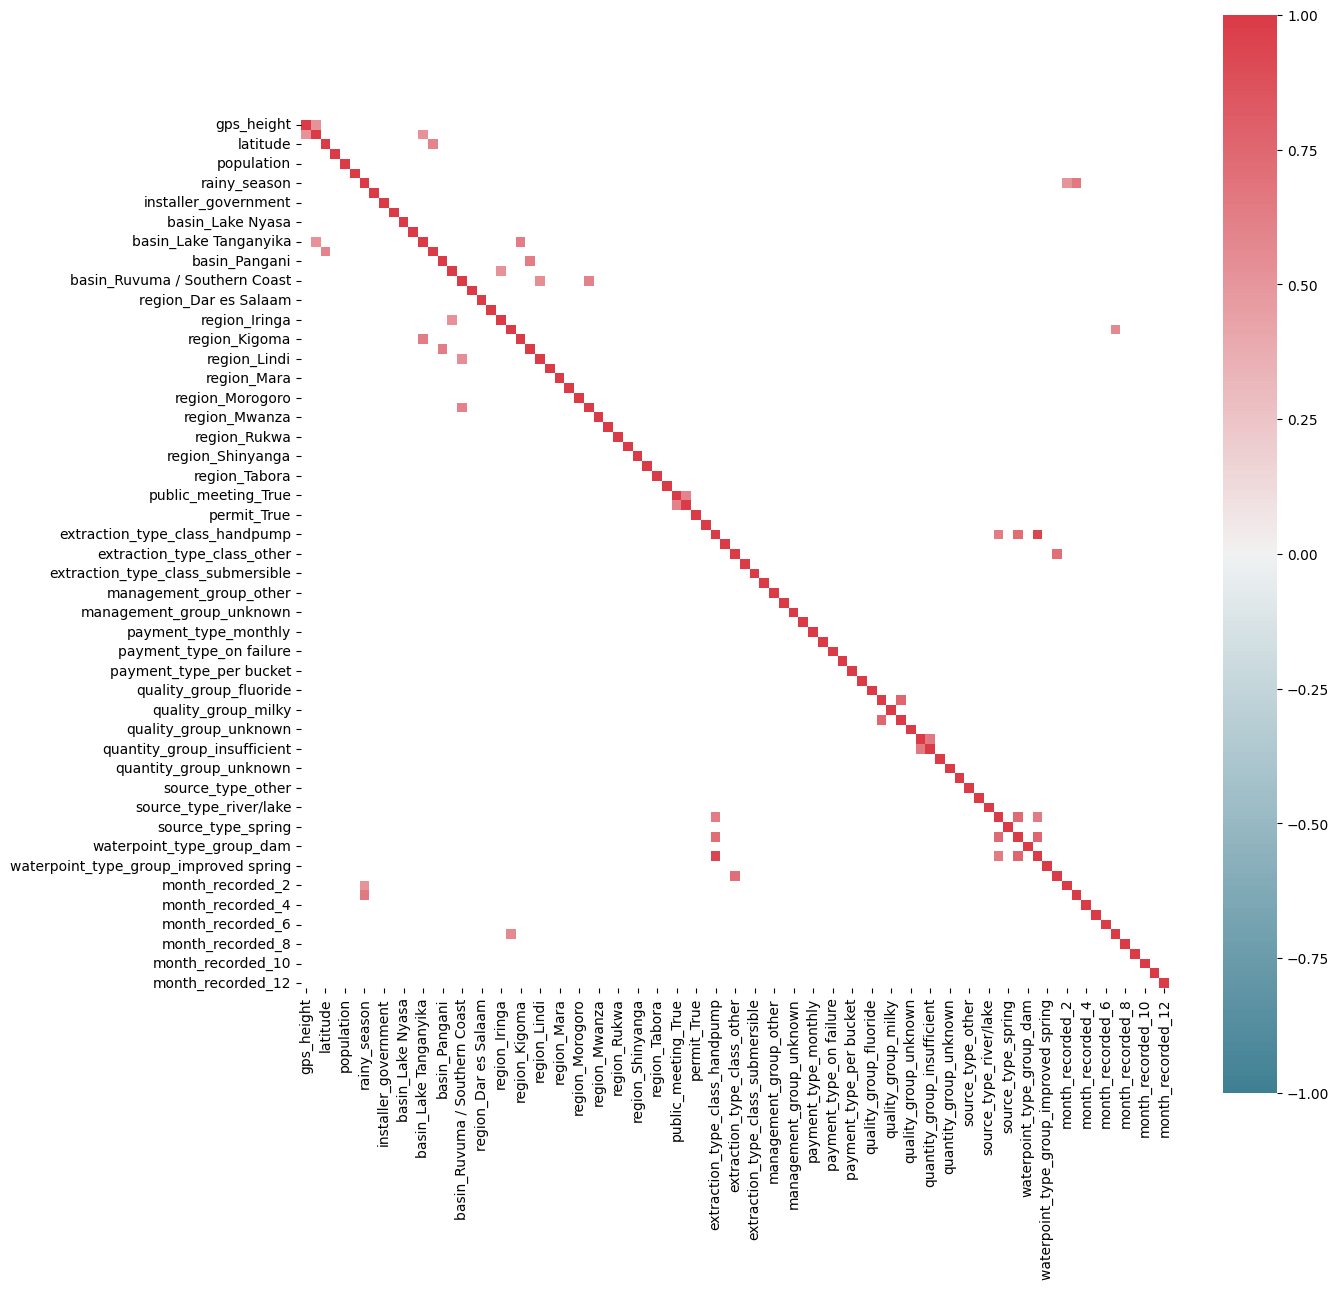

In [62]:
corr_matr = np.abs(dff.drop('id', axis=1).corr(numeric_only=True))

fig, ax = plt.subplots(figsize=(14,14))
ax = sns.heatmap(
    data=corr_matr[corr_matr>0.5],#corr_matr,
    fmt='.2f',
    # annot=corr_matr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),#'RdBu_r',
    square=True,
    vmin=-1,
    vmax=1
)

plt.show()

## Model baseline

In [63]:
bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test)

0.5456790123456791

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=3000,
    max_depth=12,
    verbose=1,
)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

test_score = rfc.score(X_test, y_test)
train_score = rfc.score(X_train, y_train)

In [115]:
print(f'Random Forest score:\n- test data {test_score*100:.2f}%\n- train data {train_score*100:.2f}%\n- difference {(train_score - test_score)*100:.2f}%')

Random Forest score:
- test data 76.40%
- train data 79.19%
- difference 2.79%


## XGBoost

In [134]:
from xgboost import XGBClassifier

# {'colsample_bytree': 0.75, 
#  'eta': 0.025, 
#  'gamma': 0.55, 
#  'max_depth': 12, 
#  'min_child_weight': 4.0, 
#  'n_estimators': 665, 
#  'reg_alpha': 0.049, 
#  'reg_lambda': 5.433, 
#  'subsample': 0.7}

model = XGBClassifier(
    base_score=.5,
    learning_rate=0.025,
    n_estimators=3000,
    max_depth=12,
    min_child_weight=4,
    subsample=0.7,#0.6,
    colsample_bytree=0.75,#0.95,
    gamma=0.7,
    reg_alpha=0.049,#0.8,
    reg_lambda=5.4,#4.35,
    objective = 'multi:softmax',
    eval_metric='merror',
)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)


In [135]:
print(f'XGBoost score:\n- test data {test_score*100:.2f}%\n- train data {train_score*100:.2f}%\n- difference {(train_score - test_score)*100:.2f}%')

XGBoost score:
- test data 80.36%
- train data 87.28%
- difference 6.92%


In [105]:
for col,val in sorted(zip(X_train.columns,model.feature_importances_), key=lambda x: x[1], reverse=True)[:20]:
    print(f'{col}\t{val:.3f}')

waterpoint_type_group_other	0.127
quantity_group_seasonal	0.079
quantity_group_enough	0.036
extraction_type_class_other	0.035
region_Iringa	0.034
quantity_group_insufficient	0.031
quantity_group_unknown	0.022
region_Mara	0.016
region_Shinyanga	0.015
quality_group_unknown	0.015
basin_Lake Nyasa	0.014
extraction_type_class_motorpump	0.014
payment_type_never pay	0.013
source_type_rainwater harvesting	0.013
region_Mtwara	0.012
region_Mbeya	0.012
region_Dodoma	0.012
installer_government	0.011
region_Kigoma	0.011
quality_group_milky	0.010


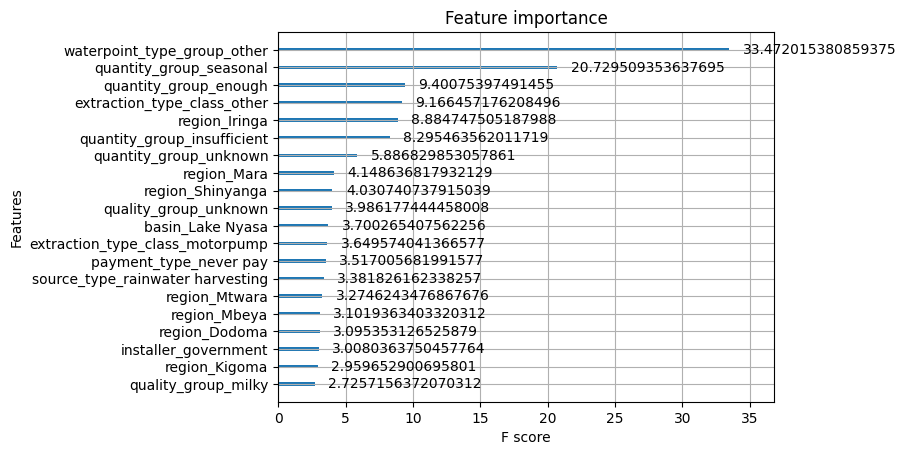

In [106]:
from xgboost import plot_importance
plot_importance(model, importance_type='gain', max_num_features=20)
plt.show()

In [107]:
from hyperopt import STATUS_OK, fmin, tpe, hp

# Define the hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, dtype=int)),
    'eta': hp.quniform('eta', 0.001, 0.5, 0.025),
    # # A problem with max_depth casted to float instead of int with
    # # the hp.quniform method.
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'reg_alpha': hp.quniform('reg_alpha', 0, 10, 0.001),
    'reg_lambda': hp.quniform('reg_lambda', 0, 10, 0.001),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
}

# Define the objective function to minimize
def objective(params):
    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print(f'Best set of hyperparameters:\n{best_params}')

100%|██████████| 100/100 [16:55<00:00, 10.15s/trial, best loss: -0.8040965207631874]
Best set of hyperparameters:
{'colsample_bytree': 0.75, 'eta': 0.025, 'gamma': 0.55, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 665, 'reg_alpha': 0.049, 'reg_lambda': 5.433, 'subsample': 0.7000000000000001}


In [137]:
print(X.shape, y.shape)

(59400, 88) (59400, 1)


In [138]:
y

,status_group
0,0
1,0
2,0
3,1
4,0
...,...
59395,0
59396,0
59397,0
59398,0


In [139]:
model_xgb = model
model_xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0.7, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.025, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [140]:
model_xgb.score(X,y)

0.8714814814814815

In [141]:
test_values = "~/Coding/drivendata/pump-it-up/data/raw/TestSetValues.csv"
test_df = feature_eng(preprocessing(pd.read_csv(test_values)))

test_df.sample(10)

,id,gps_height,longitude,latitude,private_conn,population,rainy_season,age_yrs,installer_government,installer_other,...,month_recorded_3,month_recorded_4,month_recorded_5,month_recorded_6,month_recorded_7,month_recorded_8,month_recorded_9,month_recorded_10,month_recorded_11,month_recorded_12
4529,41245,1006.000000,36.807962,-3.476677e+00,0,100.0,1,13.0,False,False,...,True,False,False,False,False,False,False,False,False,False
9577,56113,148.000000,38.845050,-5.102861e+00,0,120.0,1,12.0,False,False,...,True,False,False,False,False,False,False,False,False,False
3209,63739,1349.169811,34.171640,-2.000000e-08,0,500.0,0,8.0,False,False,...,False,False,False,False,False,False,False,False,False,False
13175,58842,299.000000,39.538661,-1.046109e+01,0,765.0,0,3.0,False,True,...,False,False,False,False,False,False,False,False,False,False
144,69202,1682.000000,37.587438,-3.219654e+00,0,1.0,0,13.0,False,True,...,False,False,False,False,False,False,False,False,False,False
3730,16117,679.918735,38.809750,-4.834024e+00,1,50.0,1,13.0,False,False,...,True,False,False,False,False,False,False,False,False,False
2,17168,1567.000000,34.767863,-5.004344e+00,0,500.0,0,3.0,False,True,...,False,False,False,False,False,False,False,False,False,False
3667,53257,1201.000000,32.007490,-6.644124e+00,0,253.0,0,25.0,False,True,...,False,False,False,False,False,False,False,False,False,False
6575,16122,1050.693435,31.592495,-1.876107e+00,0,210.0,0,8.0,False,True,...,False,False,False,False,True,False,False,False,False,False
9157,59754,1403.000000,37.195220,-3.215121e+00,0,55.0,0,18.0,False,True,...,False,False,False,False,False,False,False,False,False,False


In [143]:
FEATURES = test_df.drop(['id'], axis=1).columns

X_test_df = test_df[FEATURES]

target = model.predict(X_test_df)

target.shape

(14850,)

In [149]:
res = pd.DataFrame({'id': test_df.id, 'status_group': target})


In [150]:
res.loc[res.status_group == 0, 'status_group'] = 'functional'
res.loc[res.status_group == 1, 'status_group'] = 'non functional'
res.loc[res.status_group == 2, 'status_group'] = 'functional needs repair'

res

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [151]:
res.to_csv('submission.csv', index=False)